In [331]:
import pandas as pd
import numpy as np
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from tqdm import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [332]:
categories = [0, 1]
data_train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
data_test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)
class_names = ['Not Harmful', 'Harmful']

In [333]:
df = pd.concat([data_train,data_test])
df["objects"]=df["objects"].astype(str)
train, test = train_test_split(df, test_size=0.25)
ioi_copy=test.copy()

In [304]:
test = test.reset_index()[["binary_labels","objects"]]
train = train.reset_index()[["binary_labels","objects"]]

In [305]:
df.dtypes

binary_labels     int64
objects          object
dtype: object

In [306]:
print(train.shape)
print(test.shape)

(2525, 2)
(842, 2)


Let's use the tfidf vectorizer, commonly used for text.

In [307]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(train["objects"])
test_vectors = vectorizer.transform(test["objects"])

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [308]:
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=500,     # Number of trees in the forest.
    max_depth=30,         # Maximum depth of the trees.
    max_features="sqrt",
    min_samples_split=5,  # Minimum number of samples required to split an internal node.
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node.
    bootstrap=True,       # Use bootstrap samples when building trees.
    oob_score=True,       # Use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,            # Use all cores available.
    random_state=42,      # Random seed.
    class_weight="balanced" # Use balanced class weights to adjust for imbalanced dataset.
)
rf.fit(train_vectors, train["binary_labels"])

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [309]:
pred = rf.predict(test_vectors)
print(f' Accuracy {sklearn.metrics.accuracy_score(test["binary_labels"], pred)}')
print(f' Precision {sklearn.metrics.precision_score(test["binary_labels"], pred, average="binary")}')
print(f' Recall {sklearn.metrics.recall_score(test["binary_labels"], pred, average="binary")}')
print(f' F1-Score {sklearn.metrics.f1_score(test["binary_labels"], pred, average="binary")}')

 Accuracy 0.5724465558194775
 Precision 0.4418103448275862
 Recall 0.6699346405228758
 F1-Score 0.5324675324675324


## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implement ````predict_proba```` on raw_text lists.

In [310]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [311]:
print(c.predict_proba([test["objects"][0]]))

[[0.83965514 0.16034486]]


Now we create an explainer object. We pass the ````class_names```` as an argument for prettier display.

In [312]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [313]:
df_pred = []
for idx in range(len(test)):
    text_instance = test["objects"][idx]
    # Ensure the text is valid and non-empty
    if text_instance and len(text_instance.split()) > 0:
        exp = explainer.explain_instance(text_instance, c.predict_proba, num_features=10)
        print('Document id: %d' % idx)
        dict_pred = {
            "id": idx,
            "Prob (Harmful)": c.predict_proba([text_instance])[0, 1],
            "True Class": class_names[train["binary_labels"][idx]],
            "Explainers": exp.as_list()
        }
        df_pred.append(dict_pred)
    else:
        print(f'Skipping document id: {idx} due to insufficient text')


Document id: 0
Skipping document id: 1 due to insufficient text
Document id: 2
Document id: 3
Document id: 4
Document id: 5
Document id: 6
Document id: 7
Document id: 8
Document id: 9
Document id: 10
Document id: 11
Document id: 12
Document id: 13
Skipping document id: 14 due to insufficient text
Document id: 15
Document id: 16
Document id: 17
Document id: 18
Document id: 19
Document id: 20
Document id: 21
Document id: 22


KeyboardInterrupt: 

In [ ]:
df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"]>=0.5,"Harmful","Not Harmful")
df_pred

,id,Prob (Harmful),True Class,Explainers,Prob Class
0,0,0.664782,Harmful,"[(person, 0.08099206325725805), (bottle, 0.073...",Harmful
1,1,0.263630,Not Harmful,"[(dog, -0.026813842315424566)]",Not Harmful
2,2,0.541969,Not Harmful,"[(person, 0.08039191940583561)]",Harmful
3,3,0.287925,Harmful,"[(cat, -0.09966802647423104), (baseball, 0.016...",Not Harmful
4,4,0.391513,Harmful,"[(person, 0.11497689978226594), (vase, -0.0933...",Not Harmful
...,...,...,...,...,...
787,837,0.201320,Harmful,"[(laptop, -0.3118997910411408), (cup, -0.04183...",Not Harmful
788,838,0.541969,Not Harmful,"[(person, 0.08039191940583557)]",Harmful
789,839,0.287020,Not Harmful,"[(person, -0.29932985310080007), (clock, -0.10...",Not Harmful
790,840,0.755557,Not Harmful,"[(person, 0.1680527892614941), (tie, 0.0398618...",Harmful


In [ ]:
explainer_list=[]
c=0
for i in df_pred["Explainers"]:
    for k in i:
        explainer_dict={
            "id": c,
            "word":k[0],
            "value":k[1]
        }
        explainer_list.append(explainer_dict)
    c+=1
        
        
explainer_list=pd.DataFrame(explainer_list)
explainer_list = explainer_list.merge(df_pred, on="id")
explainer_list

,id,word,value,Prob (Harmful),True Class,Explainers,Prob Class
0,0,person,0.080992,0.664782,Harmful,"[(person, 0.08099206325725805), (bottle, 0.073...",Harmful
1,0,bottle,0.073169,0.664782,Harmful,"[(person, 0.08099206325725805), (bottle, 0.073...",Harmful
2,1,dog,-0.026814,0.263630,Not Harmful,"[(dog, -0.026813842315424566)]",Not Harmful
3,2,person,0.080392,0.541969,Not Harmful,"[(person, 0.08039191940583561)]",Harmful
4,3,cat,-0.099668,0.287925,Harmful,"[(cat, -0.09966802647423104), (baseball, 0.016...",Not Harmful
...,...,...,...,...,...,...,...
1566,789,person,-0.299330,0.541969,Harmful,"[(person, 0.0803919194058356)]",Harmful
1567,789,clock,-0.104858,0.541969,Harmful,"[(person, 0.0803919194058356)]",Harmful
1568,789,tv,-0.057227,0.541969,Harmful,"[(person, 0.0803919194058356)]",Harmful
1569,790,person,0.168053,0.796817,Not Harmful,"[(person, 0.1787159550064864), (tie, 0.0505195...",Harmful


In [ ]:
harmful_count = explainer_list.groupby(['word', 'Prob Class']).size().reset_index(name='count')
harmful_count = harmful_count.pivot_table(index='word', columns='Prob Class', values='count', fill_value=0)
harmful_count.columns = ['Not Harmful', 'Harmful']
harmful_count.reset_index(inplace=True)

harmful_count["count"] = harmful_count["Not Harmful"]+harmful_count["Harmful"]
harmful_count=harmful_count.sort_values(by="count", ascending=False).head(10)
#harmful_count = harmful_count.pivot_table(index='word', values=['Not Harmful', 'Harmful'], aggfunc='sum')
harmful_count

,word,Not Harmful,Harmful,count
53,person,360.0,298.0,658.0
71,tie,68.0,66.0,134.0
29,dog,33.0,23.0,56.0
14,bottle,25.0,18.0,43.0
23,chair,20.0,17.0,37.0
77,tv,24.0,12.0,36.0
27,cup,16.0,17.0,33.0
13,book,13.0,16.0,29.0
21,cat,19.0,10.0,29.0
22,cell,15.0,12.0,27.0


## Visualizing explanations

In [ ]:
harmful_long = pd.melt(harmful_count, id_vars='word', var_name='Result', value_name='Count')
harmful_long.sort_values(by="word")

,word,Result,Count
27,book,count,29.0
7,book,Not Harmful,13.0
17,book,Harmful,16.0
3,bottle,Not Harmful,25.0
23,bottle,count,43.0
13,bottle,Harmful,18.0
18,cat,Harmful,10.0
8,cat,Not Harmful,19.0
28,cat,count,29.0
29,cell,count,27.0


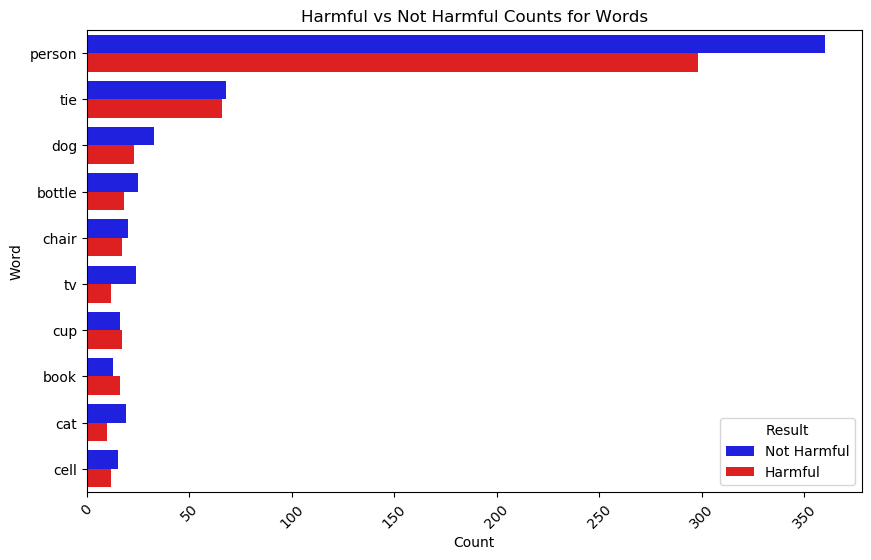

In [ ]:
# Correcting the code snippet provided by the user and plotting the barplot accordingly
# First, we'll need to convert the DataFrame from wide to long format

# For the given data, we can use 'pd.melt' instead of 'pd.wide_to_long' for simplici
# Now, let's create the barplot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='Count', hue='Result', data=harmful_long[harmful_long["Result"]!="count"], palette=['blue', 'red'])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Words')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Top10HarmfulHarmlessObjectsCount.jpeg")


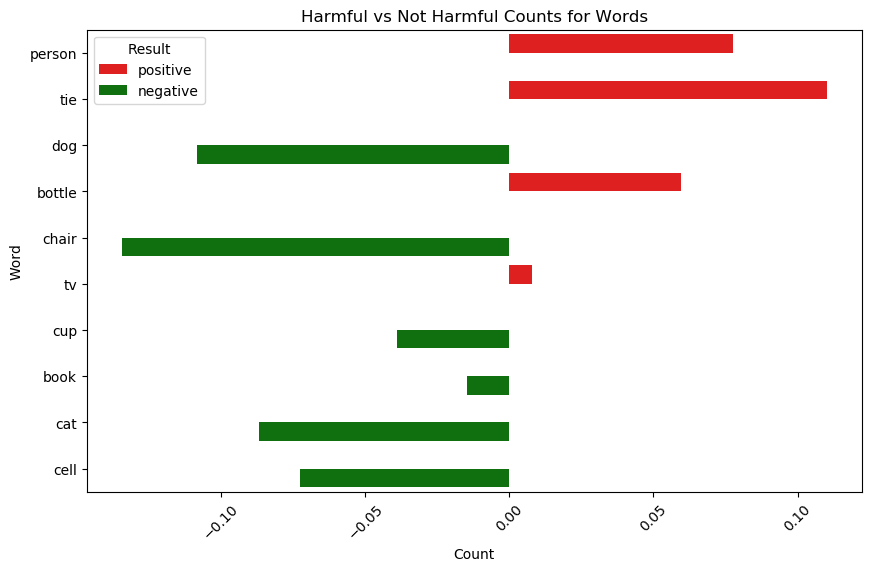

In [ ]:
exp_val =explainer_list[["word","value"]].groupby("word").mean("value")
exp_val["dir"] = np.where(exp_val["value"]>=0,"positive","negative")

top10=harmful_long[harmful_long["Result"]!="count"][["word"]].drop_duplicates()

top10 = top10.merge(exp_val, how="inner",on="word")


plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='value',hue="dir" , data=top10, palette=["red","green"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Words')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Top10HarmfulHarmlessObjectsValues.jpeg")


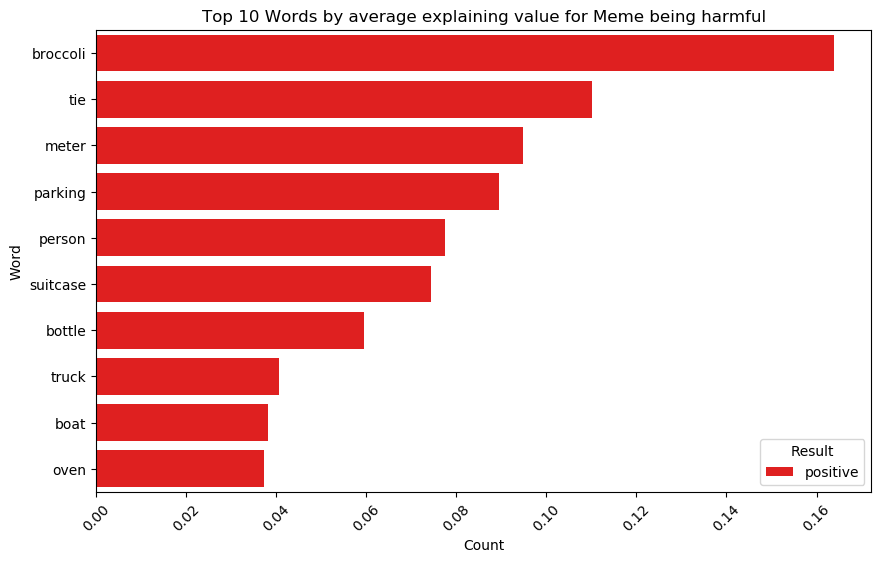

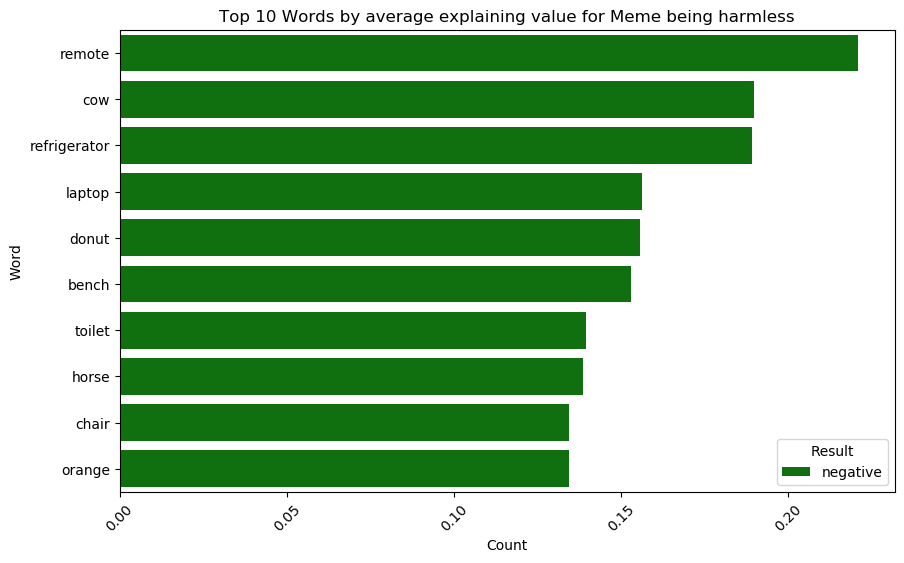

In [ ]:
exp_p = exp_val[exp_val["dir"]=="positive"].sort_values("value",ascending=False).head(10)
exp_n = exp_val[exp_val["dir"]=="negative"].sort_values("value",ascending=True).head(10)
exp_n["value"]=exp_n["value"]*-1

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_p.index, x='value',hue="dir" , data=exp_p, palette=["red"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Words by average explaining value for Meme being harmful')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Positive_Top10ObjectsByValues.jpeg")

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_n.index, x='value',hue="dir" , data=exp_n, palette=["green"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Words by average explaining value for Meme being harmless')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Negative_Top10ObjectsByValues.jpeg")


## Broccoli investigation

In [339]:
ioi = ioi_copy
ioi = ioi[ioi["objects"].str.contains("broccoli")]
ioi

,Unnamed: 0,Unnamed: 0_x,id,img,labels,text,processed_text,processed_text_alt,binary_labels,Unnamed: 0_y,objects,text_and_objects,ind
1381,1381,1381,covid_memes_5102,covid_memes_5102.png,"['very harmful', 'society']",#Fact Check\nBREAKING NEWS\nCOCAINE KILLS CORO...,fact check breaking news cocaine kills coronav...,fact check breaking news cocaine kill coronavi...,1,1359,broccoli,fact check breaking news cocaine kill coronavi...,1381
1406,1406,1406,covid_memes_5334,covid_memes_5334.png,"['very harmful', 'society']",Vvek Rajan Agihetno\nSolution to a lot of worl...,vvek rajan agihetno solution lot world problem...,vvek rajan agihetno solution lot world problem...,1,246,broccoli bowl,vvek rajan agihetno solution lot world problem...,1406
1970,1970,1970,covid_memes_3312,covid_memes_3312.png,"['somewhat harmful', 'society']",Thee\nUVE BREAKINGMEws werDKLSconcoa VuS\n7SCE...,thee uve breakingmews werdklsconcoa vus 7scent...,thee uve breakingmews werdklsconcoa vus 7scent...,1,1180,broccoli,thee uve breakingmews werdklsconcoa vus 7scent...,1970
2593,2593,2593,covid_memes_4280,covid_memes_4280.png,['not harmful'],2020 be like\nA\n,like,2020 like,0,1972,broccoli teddy bear,2020 like broccoli teddy bear,2593
